In [118]:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing  

import math              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cmath 
from sympy import symbols, I, exp, diff, lambdify
import numpy as np


In [211]:
"All lengths given in units of the wavelength lambda"
l_1 = [0.510,0.490,0.430,0.430,0.430] #antenna lengths. 
l_2 =[0.003, 0.003, 0.003, 0.003, 0.003] #antenna radii
l_3 = [(0,0), (0.5,0), (1,0), (1.5,0), (2,0)] #antenna position

V = [0, 1, 0, 0, 0] #voltage in each antenna

def G(p, q, k, z, z_1, L_1, L_2, L_3):
   
    """

    Parameters
    ----------
    p, q: antenna indexes
    k : wavenumber
    z : 
    z_1 : z'

    Returns so called impedance kernel
    -------
    """

    #print(L_2)
    if p == q:
        d = L_2[p]
    else:
        d = math.sqrt((L_3[p][0] - L_3[q][0])**2+ (L_3[p][1] - L_3[q][1])**2)
    #print(d)
    R = math.sqrt((z - z_1)**2 + d**2)
    if R < 1e-6:  # threshold for small distances
        return 0 
    #print(R)
    return (cmath.exp(-k * R*1j))/R

def second_derivative_G(p, q, k, z, z_1, L_1, L_2, L_3):
    if p == q:
        d = L_2[p]
    else:
        dx = L_3[p][0] - L_3[q][0]
        dy = L_3[p][1] - L_3[q][1]
        d = math.sqrt(dx**2 + dy**2)
    
    delta_z = z - z_1
    R = math.sqrt(delta_z**2 + d**2)
    
    if R < 1e-10:  # Use a smaller threshold
        return 0
    
    exp_term = cmath.exp(-1j * k * R)
    
    # Correction des termes:
    # Terme constant (qui ne dépend pas de delta_z²)
    constant_term = (1/R**3) * exp_term
    
    # Terme avec delta_z²
    delta_z_squared_term = ((3*delta_z**2/R**5) * exp_term)
    
    # Terme avec jk
    jk_term = (-1j*k/R**2 - 3j*k*delta_z**2/R**4) * exp_term
    
    # Terme avec k²
    k_squared_term = (-k**2*delta_z**2/R**3) * exp_term
    
    return constant_term + delta_z_squared_term + jk_term + k_squared_term

def Z(p, q, k):
    """
    Compute the coefficient of entry (p, q) of the impedance matrix

    """
    global L_1, L_2, L_3
    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l_1]
    L_2 = [l*wavelength for l in l_2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l_3]
    h_p = L_1[p]/2
    h_q = L_1[q]/2
    if p == q:
        N = 300 
    else:
        N = 200
    Z = 0
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    
    for n in range(-N//2, N//2+1):
        z = (n*2*h_p)/N
        delta = 0.002
        lower = math.floor((z-delta)*N/(2*h_p))
        upper = math.ceil((z+delta)*N/(2*h_p))
        intervals = [[-N//2, lower], [lower, upper+1], [upper+1, N//2+1]]
        weight = [50, 500, 50]
        dz = 2*h_p/N
        for m in range(intervals[0][0], intervals[0][1]): #first interval
              M0 = weight[0]
              z_1 = (m*2*h_q)/M0
              dz_1 = 2*h_q/M0
              g = G(p, q, k, z, z_1, L_1, L_2, L_3)
              g_sec = second_derivative_G(p, q, k, z, z_1, L_1, L_2, L_3)
              sinp = math.sin(k*(h_p - abs(z)))/(math.sin(k*h_p))
              sinq = math.sin(k*(h_q- abs(z_1)))/(math.sin(k*h_q))
              Z += complex(0, eta/(4*math.pi*k))*sinp*sinq*(g*k**2+g_sec)*dz*dz_1
                
        for m in range(intervals[1][0], intervals[1][1]): #second interval
              M1 = weight[1]
              z_1 = (m*2*h_q)/M1
              dz_1 = 2*h_q/M1
              g = G(p, q, k, z, z_1, L_1, L_2, L_3)
              g_sec = second_derivative_G(p, q, k, z, z_1, L_1, L_2, L_3)
              sinp = math.sin(k*(h_p - abs(z)))/(math.sin(k*h_p))
              sinq = math.sin(k*(h_q- abs(z_1)))/(math.sin(k*h_q))
              Z += complex(0, eta/(4*math.pi*k))*sinp*sinq*(g*k**2+g_sec)*dz*dz_1
                
        for m in range(intervals[2][0], intervals[2][1]): #third interval
              M2 = weight[2]
              z_1 = (m*2*h_q)/M2
              dz_1 = 2*h_q/M2
              g = G(p, q, k, z, z_1, L_1, L_2, L_3)
              g_sec = second_derivative_G(p, q, k, z, z_1, L_1, L_2, L_3)
              sinp = math.sin(k*(h_p - abs(z)))/(math.sin(k*h_p))
              sinq = math.sin(k*(h_q- abs(z_1)))/(math.sin(k*h_q))
              Z += complex(0, eta/(4*math.pi*k))*sinp*sinq*(g*k**2+g_sec)*dz*dz_1
              
    return Z   

In [212]:
def matrixZ(k):
    n = len(l_1) #nb of antennas
    #matZ = np.matrix([[Z(p,q,k) for q in range(0,n)] for p in range(0,n)])
    matZ= np.zeros((n, n), dtype=complex)
    for p in range(0, n):
        for q in range(0, p+1):
            Z_pq =  Z(p,q,k)
            if p == q:
                matZ[p][q] = Z_pq
            else:
                matZ[p][q] = Z_pq
                matZ[q][p] = Z_pq
    return matZ

In [213]:
def input_current(V,Z):
    I = np.linalg.solve(Z, V)
    return I  

In [214]:
matrixZ(10)

array([[ 3.99471070e+04+5.53954312e+05j,  2.16428012e+01-4.07287440e+01j,
        -1.08832069e+01-2.15133069e+00j,  2.23962917e+00+4.50752134e+00j,
         4.76674088e-01-2.95201538e+00j],
       [ 2.16428012e+01-4.07287440e+01j,  3.68451880e+04+5.11506376e+05j,
         2.00315067e+01-3.18477124e+01j, -1.07988089e+01-2.51890408e+00j,
         2.97679769e+00+4.62651361e+00j],
       [-1.08832069e+01-2.15133069e+00j,  2.00315067e+01-3.18477124e+01j,
         2.91204076e+04+4.06556329e+05j,  2.21413335e+01-2.40095632e+01j,
        -1.22862862e+01-3.89531406e+00j],
       [ 2.23962917e+00+4.50752134e+00j, -1.07988089e+01-2.51890408e+00j,
         2.21413335e+01-2.40095632e+01j,  2.91204076e+04+4.06556329e+05j,
         2.21413335e+01-2.40095632e+01j],
       [ 4.76674088e-01-2.95201538e+00j,  2.97679769e+00+4.62651361e+00j,
        -1.22862862e+01-3.89531406e+00j,  2.21413335e+01-2.40095632e+01j,
         2.91204076e+04+4.06556329e+05j]])

In [210]:
V = [0,1,0,0,0]
input_current(V,matrixZ(10))

array([ 8.70393207e-11-1.19523256e-10j,  1.32948524e-07-1.85532240e-06j,
        1.03735408e-10-1.22772933e-10j, -4.40332418e-11-1.69357958e-11j,
        9.76607068e-12+2.11698511e-11j])

In [188]:
import numpy as np
import math
import cmath
from scipy.special import roots_legendre

def Z_Gauss(p, q, k):
    """
    Compute the coefficient of entry (p, q) of the impedance matrix using Gauss-Legendre quadrature
    with focus on regions where z is close to z_1.
    """
    global L_1, L_2, L_3
    wavelength = 2 * math.pi / k
    L_1 = [l * wavelength for l in l_1]
    L_2 = [l * wavelength for l in l_2]
    L_3 = [(x * wavelength, y * wavelength) for (x, y) in l_3]
    
    h_p = L_1[p] / 2
    h_q = L_1[q] / 2
    eta = 376.7  # impedance of free space
    
    # Define a small region around the singularity
    delta = 0.01 * h_q if p == q else 0.05 * h_q
    
    # Define just three regions for z
    z_regions = [(-h_q, -delta), (-delta, delta), (delta, h_q)]
    N_z = 150  # Points for z integration
    
    Z = 0
    for z_region in z_regions:
        a_z, b_z = z_region
        # Calculate unique nodes and weights for this z interval
        nodes_z, weights_z = roots_legendre(N_z)
        nodes_z_mapped = 0.5 * (nodes_z + 1) * (b_z - a_z) + a_z
        weights_z_mapped = 0.5 * weights_z * (b_z - a_z)
        
        for i in range(N_z):
            z = nodes_z_mapped[i]
            dz = weights_z_mapped[i]
            
            # For each z, define regions for z_1 centered around the current z value
            # This focuses integration points where they're most needed: when z ≈ z_1
            z1_regions = [(max(-h_q, z-delta), min(z+delta, h_q))]  # Region where z ≈ z_1
            
            # Add regions before and after if they exist
            if max(-h_q, z-delta) > -h_q:
                z1_regions.insert(0, (-h_q, max(-h_q, z-delta)))
            if min(z+delta, h_q) < h_q:
                z1_regions.append((min(z+delta, h_q), h_q))
            
            # Use more points for region where z ≈ z_1
            N_z1_close = 200  # More points where z is close to z_1
            N_z1_far = 100    # Fewer points elsewhere
            
            for idx, z1_region in enumerate(z1_regions):
                a_z1, b_z1 = z1_region
                # Skip empty regions
                if a_z1 >= b_z1:
                    continue
                
                # Use more points when z ≈ z_1
                N_z1 = N_z1_close if idx == 0 else N_z1_far
                
                # Calculate unique nodes and weights for this z_1 interval
                nodes_z1, weights_z1 = roots_legendre(N_z1)
                nodes_z1_mapped = 0.5 * (nodes_z1 + 1) * (b_z1 - a_z1) + a_z1
                weights_z1_mapped = 0.5 * weights_z1 * (b_z1 - a_z1)
                
                for j in range(N_z1):
                    z_1 = nodes_z1_mapped[j]
                    dz_1 = weights_z1_mapped[j]
                    
                    # Calculate Green's function and its second derivative
                    g = G(p, q, k, z, z_1, L_1, L_2, L_3)
                    g_sec = second_derivative_G_corrected(p, q, k, z, z_1, L_1, L_2, L_3)
                    
                    # Calculate sine terms
                    sinp = np.sin(k * (h_p - abs(z))) / np.sin(k * h_p)
                    sinq = np.sin(k * (h_q - abs(z_1))) / np.sin(k * h_q)
                    
                    # Calculate contribution to impedance
                    Z += complex(0, eta / (4 * np.pi * k)) * sinp * sinq * (g * k**2 + g_sec) * dz * dz_1
    
    return Z

In [189]:
Z_Gauss(2, 2, 100)

(28852.314620864672+400972.01351711445j)

In [190]:
def matrixZ_Gauss(k):
    n = len(l_1) #nb of antennas
    matZ = np.matrix([[Z_Gauss(p,q,k) for q in range(0,n)] for p in range(0,n)])
    return matZ

In [191]:
matrixZ_Gauss(100)

KeyboardInterrupt: 

In [127]:
V = [0,1,0,0,0]
input_current(V,matrixZ_Gauss(100))

array([-1.55290400e-11-7.49818223e-11j,  1.40610642e-07-2.00416178e-06j,
       -1.54341220e-11-7.87186204e-11j,  1.28159455e-12+3.68352616e-11j,
        5.41587520e-13-2.41725714e-11j])

In [179]:
def integrand(p, q, k, z):
    global L_1, L_2, L_3
    wavelength = 2 * math.pi / k
    L_1 = [l * wavelength for l in l_1]
    L_2 = [l * wavelength for l in l_2]
    L_3 = [(x * wavelength, y * wavelength) for (x, y) in l_3]
    h_p = L_1[p]/2
    print(h_p)
    h_q = L_1[q]/2
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    z_1 = np.linspace(-h_q,h_q, 500)
    if p == q:
        d = L_2[p]
    else:
        d = math.sqrt((L_3[p][0] - L_3[q][0])**2+ (L_3[p][1] - L_3[q][1])**2)
    R = np.sqrt((z - z_1)**2 + d**2)
    
    g = (np.exp(-k * R*1j))/R
    exp_term = np.exp(-1j * k * R)
    term1 = (1/R**3 - 1j*k/R**2) * exp_term  # Constant term
    term2 = ((3/R**5 - 3*1j*k/R**4 - k**2/R**3) * (z - z_1)**2) * exp_term  # z² term
    
    g_sec = term1 + term2
   
    sinp = np.sin(k*(h_p - abs(z)))/(math.sin(k*h_p))
    sinq = np.sin(k*(h_q- abs(z_1)))/(math.sin(k*h_q))
    
    #Define function
    f_z = complex(0, eta/(4*math.pi*k))*sinp*sinq*(g*k**2+g_sec)
   

    # Plot it
    plt.plot(z_1, abs(f_z))
    plt.xlabel("z'")
    plt.ylabel("f(z')")
    plt.title("Plot of the integrand")
    plt.grid(True)
    plt.show()

0.01350884841043611


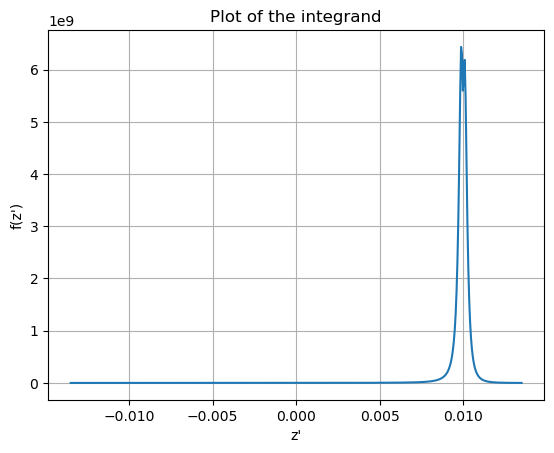

In [181]:
integrand(2, 2, 100, 0.01)

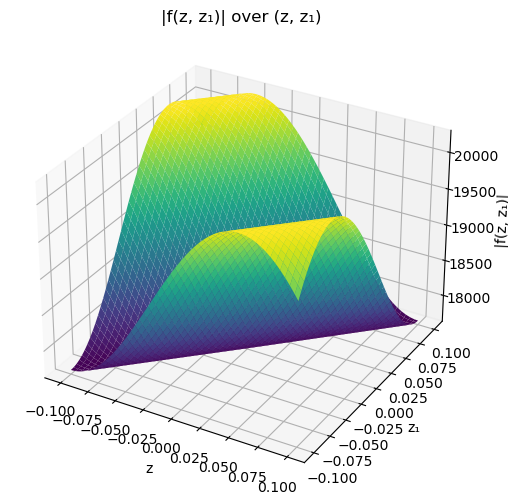

In [192]:
def integrand_grid(p, q, k, z_range, z1_range):
    global L_1, L_2, L_3
    wavelength = 2 * math.pi / k
    L_1 = [l * wavelength for l in l_1]
    L_2 = [l * wavelength for l in l_2]
    L_3 = [(x * wavelength, y * wavelength) for (x, y) in l_3]
    h_p = L_1[p] / 2
    h_q = L_1[q] / 2
    eta = 376.7

    Z, Z1 = np.meshgrid(z_range, z1_range)

    if p == q:
        d = L_2[p]
    else:
        dx = L_3[p][0] - L_3[q][0]
        dy = L_3[p][1] - L_3[q][1]
        d = math.sqrt(dx**2 + dy**2)

    R = np.sqrt((Z - Z1)**2 + d**2)

    g = (np.exp(-1j * k * R)) / R
    exp_term = np.exp(-1j * k * R)
    term1 = (1 / R**3 - 1j * k / R**2) * exp_term
    term2 = ((3 / R**5 - 3j * k / R**4 - k**2 / R**3) * (Z - Z1)**2) * exp_term
    g_sec = term1 + term2

    sinp = np.sin(k * (h_p - np.abs(Z))) / np.sin(k * h_p)
    sinq = np.sin(k * (h_q - np.abs(Z1))) / np.sin(k * h_q)

    f = 1j * eta / (4 * np.pi * k) * sinp * sinq * (g * k**2 + g_sec)

    return Z, Z1, np.abs(f)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Setup test values
p, q = 0, 0
k = 2 * np.pi / 100  # wavelength 

z_vals = np.linspace(-0.1, 0.1, 200)
z1_vals = np.linspace(-0.1, 0.1, 200)

Z, Z1, F = integrand_grid(p, q, k, z_vals, z1_vals)

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, Z1, F, cmap='viridis')
ax.set_title("|f(z, z₁)| over (z, z₁)")
ax.set_xlabel("z")
ax.set_ylabel("z₁")
ax.set_zlabel("|f(z, z₁)|")
plt.show()
